<a href="https://colab.research.google.com/github/KazGet/Summer_prac_ML/blob/main/Summer_practies_3_2_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Импорт библиотек
!pip install catboost
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# from google.colab import drive; drive.mount('/content/drive')
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, recall_score, RocCurveDisplay, roc_auc_score, make_scorer
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from xgboost import XGBClassifier, XGBRegressor, plot_importance
from sklearn.preprocessing import OrdinalEncoder, StandardScaler, label_binarize, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import RFE, RFECV, SelectKBest, f_classif
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer, KNNImputer
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.linear_model import Lasso, LassoCV
from sklearn.pipeline import Pipeline
!pip install missforest
from missforest import MissForest
!pip install optuna
import optuna
import shap
!pip install boruta
from boruta import BorutaPy
import itertools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 20.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.9/57.9 kB 2.6 MB/s eta 0:00:00


In [ ]:
# @title Импорт основого файла и предобработка данных
file = "/content/3_task.xlsx"
df = pd.read_excel(file, sheet_name=2)
#Предсказание попадания пациента в группу 3 по данным стресс-ЭхоКГ — графы СR-GJ
df = df.rename(columns={'Phenotype angio: 0 - анат-, гемо-, 1- анат-, гемо + (по ФРК, где есть), 2 - анат+, гемо -, 3 - анат+, гемо +': 'Phenotype_angio'})
df=df.rename(columns={'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма': 'Phenotype_Стресс'})

df=df.drop(['DTE rest',  'DTE stress', 'S RV  stress',
            'LVESVi stress', 'LVESVi at rest', 'Peak ECG'], axis=1)

categorical_features = ['Reason of Stress Stop']
df[categorical_features] = df[categorical_features].fillna("NaN").astype(str)

df['target'] = (df['Phenotype_angio'] == 3).astype(int)
df.drop(['Phenotype_angio'], axis=1, inplace=True)
X = df.drop('target', axis=1)
y = df['target']

# encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# X[categorical_features] = encoder.fit_transform(X[categorical_features])
# X.columns = X.columns.astype(str)
# X.columns = X.columns.str.replace(r'[\[\]<>]', '', regex=True)

In [ ]:
# @title Удаление полупустых признаков и заполнение медианой
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > 0.3].index
df_dropped = df.drop(cols_to_drop, axis=1)

X_dropped = df_dropped.drop('target', axis=1)

encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_dropped[categorical_features] = encoder.fit_transform(X_dropped[categorical_features])

imputer = SimpleImputer(strategy='median')
X_filled = imputer.fit_transform(X_dropped)
X_filled_data = pd.DataFrame(X_filled, columns=X_dropped.columns)

In [ ]:
# @title Заполнение методом KNNImputer
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(X)

imputer = KNNImputer(n_neighbors=15)
df_imputed_scaled = imputer.fit_transform(df_scaled)
df_KNN = scaler.inverse_transform(df_imputed_scaled)
df_final = pd.DataFrame(df_KNN, columns=X.columns)

In [ ]:
# @title Заполнение пропусков методом Iterative Imputer
imputer = IterativeImputer(max_iter=25, random_state=0)
df_imputed = imputer.fit_transform(X)
df_MICE = pd.DataFrame(df_imputed, columns=X.columns)

/usr/local/lib/python3.11/dist-packages/sklearn/impute/_iterative.py:895: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  warnings.warn(


In [ ]:
# @title Заполнение пропусков методом MissForest
mf = MissForest(
    clf=RandomForestClassifier(n_jobs=-1),
    rgr=RandomForestRegressor(n_jobs=-1),
    categorical=categorical_features,
)
df_miss_forest = mf.fit_transform(X)

/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
100%|██████████| 5/5 [06:37<00:00, 79.45s/it]
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:490: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:494: UserWarning: In version 4.2.3, estimator fitting process is moved to `fit` method. `MissForest` will now imputes unseen missing values with fitted estimators with `transform` method. To retain the old behaviour, use `fit_transform` to fit the whole unseen data instead.
  warnings.warn(f"In version {VERSION}, estimator fitting process 

In [ ]:
# @title PCA
fig, axes = plt.subplots(4, 1, figsize=(6, 13))

datasets = [
    ("X_med", X_filled_data),
    ("df_KNN", df_final),
    ("df_MICE", df_MICE),
    ("df_MissForest", df_miss_forest)
]

for ax, (name, data) in zip(axes, datasets):
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    ax.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
    ax.axhline(0.8, color='r', linestyle='--', label='80%')
    ax.axhline(0.95, color='g', linestyle='--', label='95%')
    ax.set_xlabel('Кол-во компонент')
    ax.set_ylabel('Накопленная дисперсия')
    ax.set_title(f'PCA для {name}')
    ax.legend()
    ax.grid()

    n_components = len(list(filter(lambda x: x <= 0.95, explained_variance)))
    print(f"{name}: Компоненты, объясняющие 95% дисперсии = {n_components}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for name, data in datasets:
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label=name)

plt.axhline(0.8, color='r', linestyle='--', label='80%')
plt.axhline(0.95, color='g', linestyle='--', label='95%')
plt.xlabel('Кол-во компонент')
plt.ylabel('Накопленная дисперсия')
plt.title('PCA сравнение')
plt.legend()
plt.grid()
plt.show()


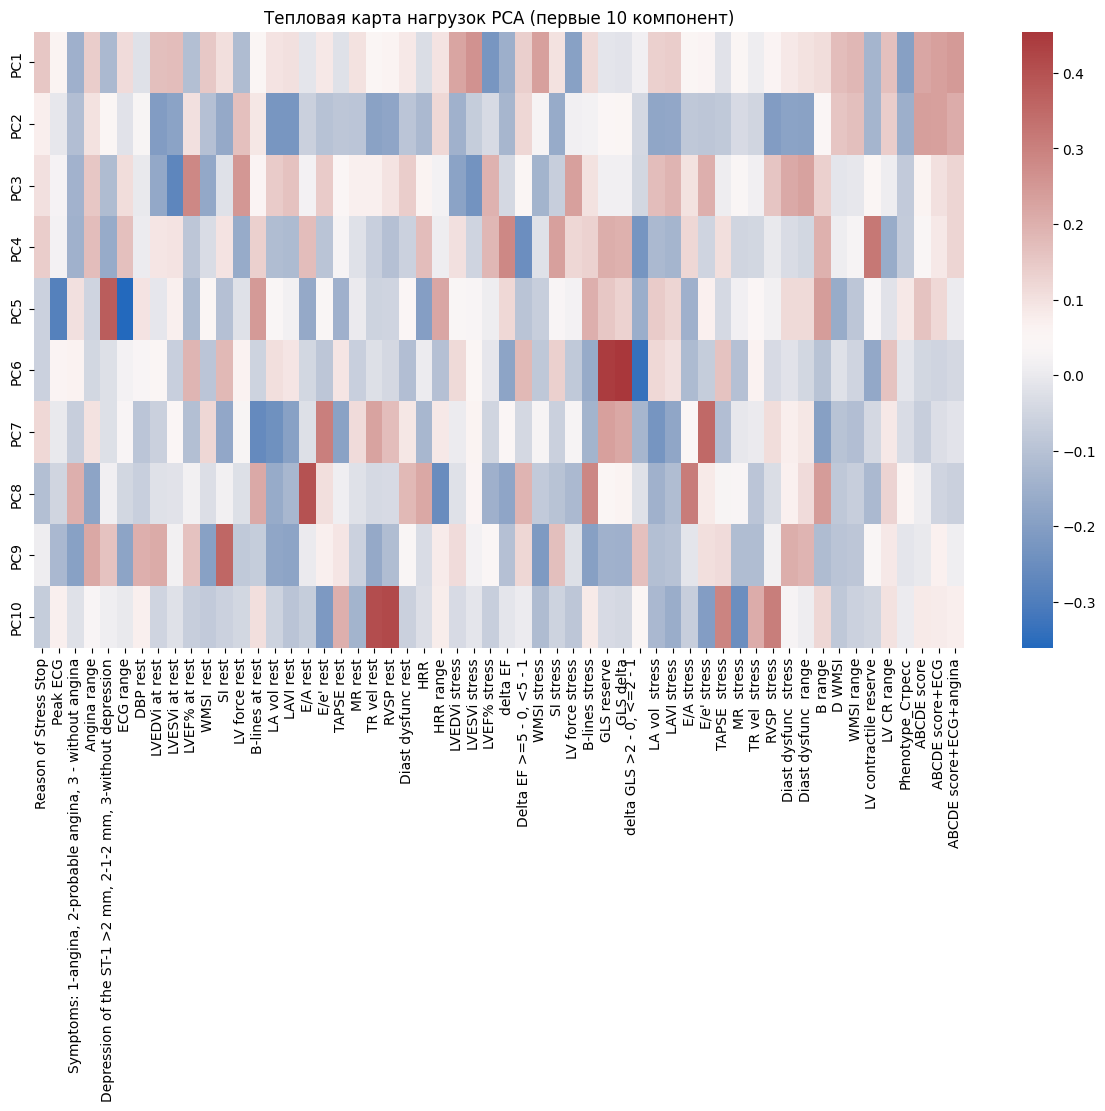

In [ ]:
# @title Отбор признаков по матрице весов PCA
X_numeric = X_filled_data.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

loadings_df = pd.DataFrame(
    data=pca.components_,
    columns=X_numeric.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
def get_most_important_features(component, loadings_df, n_features=1):
    pc_loadings = loadings_df.loc[component]
    most_important = pc_loadings.abs().sort_values(ascending=False).head(n_features)
    return loadings_df.loc[component, most_important.index]

# Визуализируем нагрузки для первых 10 компонент
plt.figure(figsize=(15, 8))
sns.heatmap(loadings_df.head(10), cmap='vlag', annot=False) # annot=True, если признаков не слишком много
plt.title('Тепловая карта нагрузок PCA (первые 10 компонент)')
plt.show()

In [ ]:
# @title Рекурсивное исключение признаков (Recursive Feature Elimination, RFE): Модель обучается на всех признаках, затем самый неважный удаляется, и процесс повторяется.
select_num = 9
selector_med = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_med.fit(X_filled, y)
selected_features_med = X_dropped.columns[selector_med.get_support()]
print("Отобранные признаки для данных, заполенными медианой: ")
print(selected_features_med.tolist())

selector_KNN = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_KNN.fit(df_KNN, y)
selected_features_KNN = X.columns[selector_KNN.get_support()]
print(f"Отобранные признаки для данных, заполенными методом ближайших соседей: ")
print(selected_features_KNN.tolist())

selector_MICE = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_MICE.fit(df_MICE, y)
selected_features_MICE = X.columns[selector_MICE.get_support()]
print(f"Отобранные признаки для данных, заполенными методом итеративного заполнения: ")
print(selected_features_MICE.tolist())

selector_MissF = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector_MissF.fit(df_miss_forest, y)
selected_features_MissF = X.columns[selector_MissF.get_support()]
print(f"Отобранные признаки для данных, заполенными методом MissForest: ")
print(selected_features_MissF.tolist())

print("\nПересечение всех признаков: ")
print(set(selected_features_med) & set(selected_features_KNN) & set(selected_features_MICE) & set(selected_features_MissF))
print("\nПересечение всех признаков: ")
print(set(selected_features_med) & set(selected_features_KNN) & set(selected_features_MICE))

Отобранные признаки для данных, заполенными медианой: 
['LA vol rest', 'HRR', 'LVEDVi stress', 'LVEF% stress', 'WMSI stress', 'LV force stress', 'D WMSI', 'Phenotype_Стресс', 'GLS stress-']
Отобранные признаки для данных, заполенными методом ближайших соседей: 
['LA vol rest', 'LVEF% stress', 'delta EF', 'WMSI stress', 'SI stress', 'D WMSI', 'LV contractile reserve', 'CFVR', 'GLS stress-']
Отобранные признаки для данных, заполенными методом итеративного заполнения: 
['LA vol rest', 'LVEF% stress', 'delta EF', 'WMSI stress', 'RAI stress', 'D WMSI', 'CFVR', 'Phenotype_Стресс', 'GLS stress-']
Отобранные признаки для данных, заполенными методом MissForest: 
['LVEF% at rest', 'LV force rest', 'E/A rest', "s' rest", 'RVSP rest', 'HRR', 'GLS reserve', 'Diast dysfunc  stress', 'D WMSI']

Пересечение всех признаков: 
{'D WMSI'}

Пересечение всех признаков: 
{'WMSI stress', 'LVEF% stress', 'GLS stress-', 'LA vol rest', 'D WMSI'}


In [ ]:
# @title Отбор признаков методом Boruta
dfrf = df_MICE
rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', random_state=42)

feat_selector = BorutaPy(
    estimator=rf,
    n_estimators='auto',
    max_iter=200,
    random_state=0,
    verbose=False
)

feat_selector.fit(dfrf.values, y.values)

selected_mask = feat_selector.support_
selected_features = dfrf.columns[selected_mask]

print("\nОтобранные признаки методом Boruta:")
print(selected_features.tolist())


Отобранные признаки методом Boruta:
['WMSI stress', 'D WMSI', 'WMSI range', 'CFVR', 'СFVR range', 'Phenotype_Стресс', 'GLS stress-']


In [ ]:
# @title RFECV —  RFE с автоматическим выбором числа признаков через кросс-валидацию
df_test = df_MICE
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
selector = RFECV(estimator=RandomForestClassifier(), step=1, cv=cv, scoring='accuracy')
selector.fit(df_test, y)
feature_ranks = selector.ranking_

ranking_df = pd.DataFrame({'feature': X.columns, 'rank': feature_ranks})
ranking_df = ranking_df.sort_values(by='rank')

top_10_features = ranking_df['feature'].head(10).tolist()

print("Топ-10 признаков из рейтинга RFECV:")
print(top_10_features)

Топ-10 признаков из рейтинга RFECV:
['LVEDVi at rest', 'LVEF% at rest', 'DBP rest', 'LAVI rest', 'RAVI rest', 'LA vol rest', "E/e' rest", 'E/A rest', 'RVSP rest', 'HRR']


In [ ]:
# @title Отбор признаков методом ANOVA: оценка стат. связи между каждым признаком и целевой переменной
datasets = {
    "медианой": (X_filled, X_dropped.columns),
    "KNN": (df_KNN, X.columns),
    "MICE": (df_MICE, X.columns),
    "MF": (df_miss_forest, X.columns),
}

selected_features_all = {}

for name, (X_data, feature_names) in datasets.items():
    selector = SelectKBest(score_func=f_classif, k=select_num)
    X_selected = selector.fit_transform(X_data, y)
    selected = feature_names[selector.get_support()]
    selected_features_all[name] = set(selected)
    print(f"Отобранные признаки с данными {name}:\n{list(selected)}")


print("\nПересечение всех результатов (медиана ∩ KNN ∩ MICE):")
print(list(
    selected_features_all["медианой"]
    & selected_features_all["KNN"]
    & selected_features_all["MICE"]
))

Отобранные признаки с данными медианой:
['LVEF% stress', 'delta EF', 'WMSI stress', 'D WMSI', 'WMSI range', 'Phenotype_Стресс', 'ABCDE score', 'ABCDE score+ECG', 'ABCDE score+ECG+angina']
Отобранные признаки с данными KNN:
['WMSI stress', 'D WMSI', 'WMSI range', 'CFVR', 'СFVR range', 'Phenotype_Стресс', 'ABCDE score', 'ABCDE score+ECG', 'ABCDE score+ECG+angina']
Отобранные признаки с данными MICE:
['LVEF% stress', 'WMSI stress', 'D WMSI', 'WMSI range', 'СFVR range', 'Phenotype_Стресс', 'ABCDE score', 'ABCDE score+ECG', 'ABCDE score+ECG+angina']
Отобранные признаки с данными MF:
['LVEDVi at rest', 'LVEF% at rest', 'WMSI  rest', 'SI rest', 'LV force rest', 'B-lines at rest', 'LA vol rest', 'HRR', 'WMSI range']

Пересечение всех результатов (медиана ∩ KNN ∩ MICE):
['WMSI stress', 'ABCDE score+ECG', 'Phenotype_Стресс', 'D WMSI', 'WMSI range', 'ABCDE score+ECG+angina', 'ABCDE score']


In [ ]:
# @title Отбор по LassoCV
def run_lasso_selection(X_source, y, name, feature_names):
    # Стандартизация + подбор alpha через кросс-валидацию
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('lasso_cv', LassoCV(cv=5, max_iter=10000))
    ])

    pipeline.fit(X_source, y)
    best_alpha = pipeline.named_steps['lasso_cv'].alpha_

    print(f"\n{name}: наилучшее значение alpha = {best_alpha:.4f}")

    # Финальная модель с выбранным alpha
    lasso = Lasso(alpha=best_alpha, max_iter=10000)
    X_scaled = StandardScaler().fit_transform(X_source)
    lasso.fit(X_scaled, y)

    # Отбор ненулевых коэффициентов
    non_zero_coefs = np.where(lasso.coef_ != 0)[0]
    selected = feature_names[non_zero_coefs]

    print(f"\nВыбранные признаки для {name}:\n", selected.tolist())
    return set(selected)

# Прогоним для всех способов заполнения
features_median = run_lasso_selection(X_filled, y, "Median", X_dropped.columns)
features_knn    = run_lasso_selection(df_KNN, y, "KNN", X.columns)
features_mice   = run_lasso_selection(df_MICE, y, "MICE", X.columns)
features_mf     = run_lasso_selection(df_miss_forest, y, "MissForest", X.columns)

# Пересечение всех
print("\nПересечение всех признаков:")
intersection = features_median & features_knn & features_mice & features_mf
print(intersection)



Median: наилучшее значение alpha = 0.0066

Выбранные признаки для Median:
 ['Reason of Stress Stop', 'ECG range', 'LVEDVi at rest', 'SI rest', 'LV force rest', 'B-lines at rest', 'LAVI rest', 'E/A rest', 'TAPSE rest', 'MR rest', 'TR vel rest', 'HRR', 'LVEDVi stress', 'LVEF% stress', 'Delta EF >=5 - 0, <5 - 1', 'WMSI stress', 'LV force stress', 'B-lines stress', 'GLS reserve', 'delta GLS >2 - 0, <=2 - 1\n', 'LA vol  stress', 'LAVI stress', 'E/A stress', "E/e' stress", 'TAPSE  stress', 'MR  stress', 'TR vel  stress', 'RVSP  stress', 'B range', 'D WMSI', 'WMSI range', 'LV CR range', 'Phenotype_Стресс', 'ABCDE score', 'ABCDE score+ECG+angina', 'GLS stress-']

KNN: наилучшее значение alpha = 0.0287

Выбранные признаки для KNN:
 ['LVEDVi at rest', 'HRR', 'WMSI stress', 'LA vol  stress', 'TAPSE  stress', 'D WMSI', 'WMSI range', 'СFVR range', 'GLS stress-']

MICE: наилучшее значение alpha = 0.0250

Выбранные признаки для MICE:
 ['LVEDVi at rest', 'SI rest', "a' rest", 'MR rest', 'HRR', 'HRR r

In [ ]:
# @title Объединение методов

#Удалим признаки с >50% пропусков
missing_percent = df.isnull().mean()
cols_to_drop = missing_percent[missing_percent > 0.4].index
df_dropped = df.drop(cols_to_drop, axis=1)
X_d = df_dropped.drop('target', axis=1)
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_d[categorical_features] = encoder.fit_transform(X_d[categorical_features])

#Используем IterativeImputer для заполнения оставшихся признаков
mf = MissForest(
    clf=RandomForestClassifier(n_jobs=-1),
    rgr=RandomForestRegressor(n_jobs=-1),
    categorical=categorical_features,
)
df_after_MF = mf.fit_transform(X_d)

imputer = IterativeImputer(max_iter=10, random_state=0)
df_after_MICE = imputer.fit_transform(X_d)
df_after_MICE = pd.DataFrame(df_after_MICE, columns=X_d.columns)

#Масшитабируем
X_numeric = df_after_MICE.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)

X_numeric_ = df_after_MF.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled_ = scaler.fit_transform(X_numeric_)

#Сделаем отбор по методу RFE
selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector.fit(X_scaled, y)
selected_features_MICE = X_d.columns[selector.get_support()]
print("Отобранные признаки методом RFE+MICE: ")
print(selected_features_MICE.tolist())

selector = RFE(estimator=RandomForestClassifier(), n_features_to_select=select_num)
selector.fit(X_scaled_, y)
selected_features_MF = X_d.columns[selector.get_support()]
print("Отобранные признаки методом RFE+MF: ")
print(selected_features_MF.tolist())

#Сделаем отбор методом ANOVA
selector_ANOVA = SelectKBest(score_func=f_classif, k=select_num)
X_anova = selector_ANOVA.fit_transform(X_scaled, y)

selector_ANOVA_ = SelectKBest(score_func=f_classif, k=select_num)
X_anova_ = selector_ANOVA_.fit_transform(X_scaled_, y)

scores = selector_ANOVA.scores_
p_values = selector_ANOVA.pvalues_

scores = selector_ANOVA_.scores_
p_values = selector_ANOVA_.pvalues_

selected_featuresMICE = X_d.columns[selector_ANOVA.get_support()]
print(f"\nОтобранные признаки методом ANOVA:\n {list(selected_featuresMICE)}")

print("Общие признаки в RFE и ANOVA:", set(selected_features_MICE) & set(selected_featuresMICE))

selected_featuresMF = X_d.columns[selector_ANOVA_.get_support()]
print(f"\nОтобранные признаки методом ANOVA (MF):\n {list(selected_featuresMF)}")

print("Общие признаки в RFE и ANOVA:", set(selected_features_MF) & set(selected_featuresMF))

/usr/local/lib/python3.11/dist-packages/missforest/missforest.py:333: UserWarning: Label encoding is no longer performed by default. Users will have to perform categorical features encoding by themselves.
  warnings.warn("Label encoding is no longer performed by default. "
  0%|          | 0/5 [00:11<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
print(set(selected_features_MF) & set(selected_featuresMF) & set(selected_features_MICE) & set(selected_featuresMICE))

Accuracy: 0.8351648351648352
Recall: 0.7586206896551724

Classification report:
               precision    recall  f1-score   support

           0       0.89      0.87      0.88        62
           1       0.73      0.76      0.75        29

    accuracy                           0.84        91
   macro avg       0.81      0.81      0.81        91
weighted avg       0.84      0.84      0.84        91


Confusion matrix:
 [[54  8]
 [ 7 22]]
ROC AUC (Train): 0.8943703755409744
ROC AUC: 0.8314794215795328


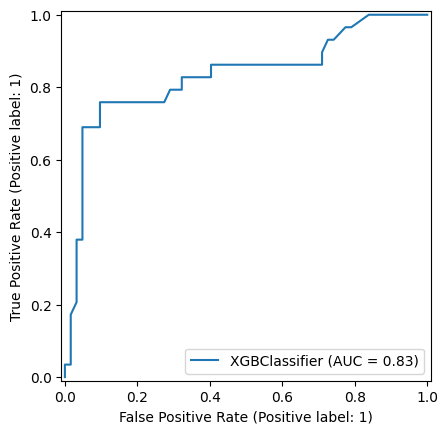

<Figure size 2000x1200 with 0 Axes>

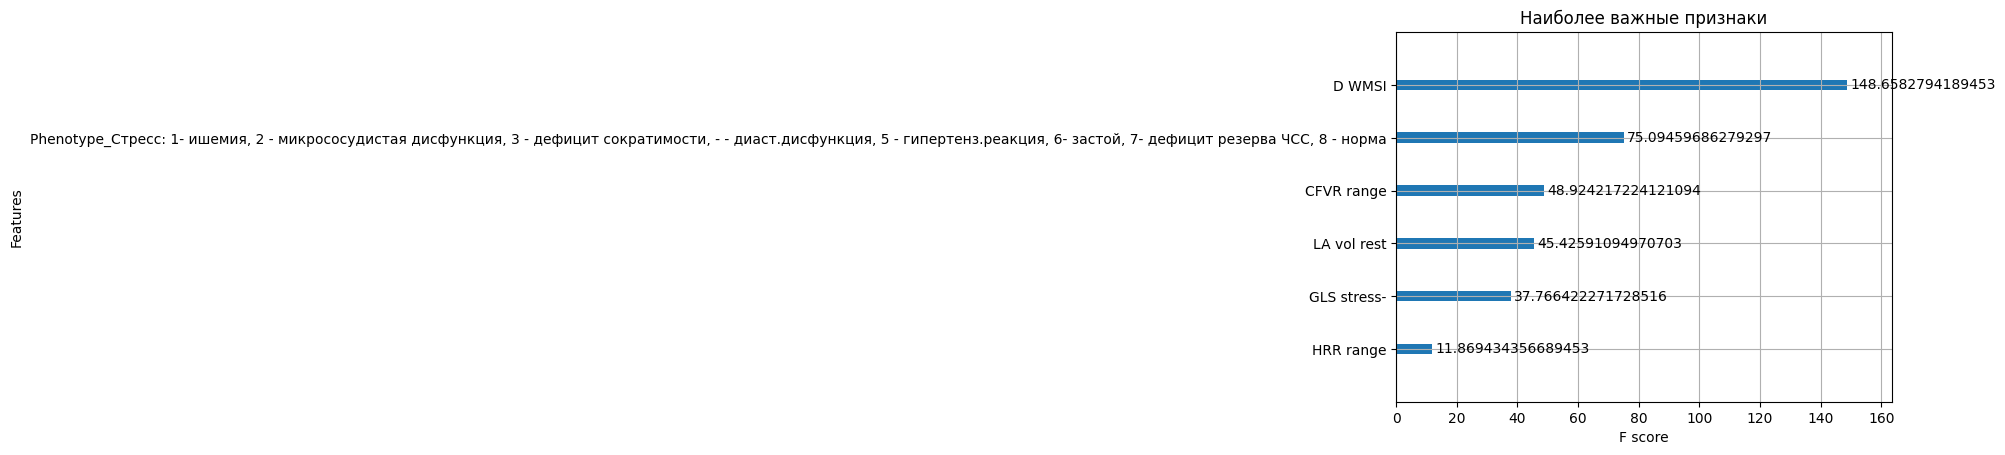

In [ ]:
# @title XGBoost

# encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
# X[categorical_features] = encoder.fit_transform(X[categorical_features])
# X.columns = X.columns.astype(str)
# X.columns = X.columns.str.replace(r'[\[\]<>]', '', regex=True)

optimal_cols = ['GLS stress-', 'D WMSI','СFVR range', 'LA vol rest','HRR range',
                'Phenotype_Стресс: 1- ишемия, 2 - микрососудистая дисфункция, 3 - дефицит сократимости, - - диаст.дисфункция, 5 - гипертенз.реакция, 6- застой, 7- дефицит резерва ЧСС, 8 - норма']
X_boost=X[optimal_cols]

X_train, X_test, y_train, y_test = train_test_split(X_boost, y, stratify=y, random_state=42, test_size=0.2)
neg = len(y_train[y_train == 0])
pos = len(y_train[y_train == 1])
scale_pos_weight = neg / pos

params = {'max_depth': 6, 'learning_rate': 0.38830158686351, 'n_estimators': 188, 'min_child_weight': 2, 'gamma': 2.5968539032497118, 'subsample': 0.9070492409605632,
          'colsample_bytree': 0.7562826912266845, 'reg_alpha': 1.319550703563934, 'reg_lambda': 5.973831576646422, 'scale_pos_weight': scale_pos_weight}

model = XGBClassifier(**params, random_state=42)

model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

plt.figure(figsize=(20, 12))
plot_importance(model, max_num_features=len(optimal_cols), importance_type='total_gain')
plt.title("Наиболее важные признаки")
plt.show()

Accuracy: 0.7142857142857143
Recall: 0.4827586206896552

Classification report:
               precision    recall  f1-score   support

           0       0.77      0.82      0.80        62
           1       0.56      0.48      0.52        29

    accuracy                           0.71        91
   macro avg       0.67      0.65      0.66        91
weighted avg       0.70      0.71      0.71        91


Confusion matrix:
 [[51 11]
 [15 14]]
ROC AUC (Train): 0.806523104844339
ROC AUC: 0.732202447163515


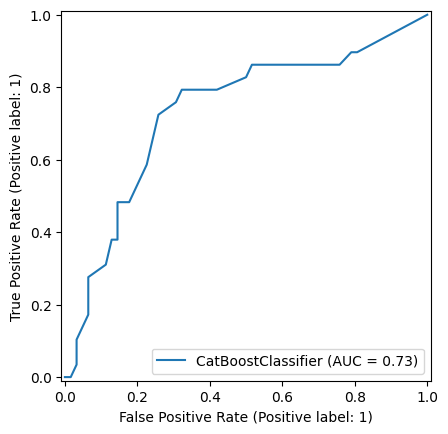

______________________________________________________________________________________________________________________________________________________
Оценки точности на каждом фолде: [0.73626374 0.56043956 0.71428571 0.7032967  0.73333333] 
Recall: [0.62068966 0.65517241 0.65517241 0.65517241 0.55172414]
Средняя точность: 0.6895 
Средний recall: 0.6276
Стандартное отклонение: 0.0657, 0.0402


In [ ]:
# @title CatBoostClassifier
# optimal_cols = ['LA vol rest', 'E/A rest', 'delta EF', 'D WMSI', 'СFVR range', 'ABCDE score+ECG+angina']
optimal_cols = ['LA vol rest', 'E/A rest', 'delta EF', 'D WMSI', 'СFVR range', 'HRR range', 'B range']
optimal_cols = optimal_cols = ['D WMSI', 'СFVR range', 'HRR range']


cat_features = [i for i in categorical_features if i in optimal_cols]

X_boost = X[optimal_cols]
X_train, X_test, y_train, y_test = train_test_split(X_boost, y, test_size=0.2, random_state=0, stratify=y)
train_pool = Pool(X_train, label=y_train, cat_features=cat_features)
test_pool = Pool(X_test, label=y_test, cat_features=cat_features)

neg = len(y_train[y_train == 0])  # или sum(y_train == 0)
pos = len(y_train[y_train == 1])  # или sum(y_train == 1)
scale_pos_weight = neg / pos

params =  {'iterations': 116, 'learning_rate': 0.10155568960633561, 'depth': 5, 'l2_leaf_reg': 9.663540417193897, 'random_strength': 1.5,
          'border_count': 64, 'scale_pos_weight': scale_pos_weight, "loss_function": "Logloss"}


cat_model = CatBoostClassifier(**params, verbose = False)
cat_model.fit(train_pool)
y_pred = cat_model.predict(test_pool)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

y_train_pred_proba = cat_model.predict_proba(train_pool)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = cat_model.predict_proba(test_pool)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(cat_model, X_test, y_test)
plt.show()


importances = cat_model.feature_importances_
indices = np.argsort(importances)[::-1]

# # Вывод важности признаков
# for i in range(len(optimal_cols)):
#     print(f"{optimal_cols[indices[i]]}: {importances[indices[i]]:.4f}")

print('_'*150)

X_cv = X_boost.copy()
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_cv[cat_features] = encoder.fit_transform(X_cv[cat_features])
test_model = CatBoostClassifier(**params, random_state=42, verbose=False)
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
scores = cross_val_score(test_model, X_cv, y, cv=cv_strategy, scoring='accuracy', verbose=False)
scores_ = cross_val_score(test_model, X_cv, y, cv=cv_strategy, scoring='recall', verbose=False)

# 4. Анализируем результаты
print(f"Оценки точности на каждом фолде: {scores} \nRecall: {scores_}")
print(f"Средняя точность: {scores.mean():.4f} \nСредний recall: {scores_.mean():.4f}")
print(f"Стандартное отклонение: {scores.std():.4f}, {scores_.std():.4f}")

In [ ]:
# @title Итеративный отбор на основе построенной модели
import itertools
optimal_cols =  ['E/A rest', 'delta EF', 'D WMSI', 'СFVR range', 'HRR range', 'B range', 'ABCDE score+ECG+angina',
                 'LVEF% at rest', 'LVEF% stress', 'RAI stress', 'TAPSE  stress']
try:
    results_brute_force
except NameError:
    results_brute_force = pd.DataFrame(columns=['n_features', 'features', 'weighted_score'])

params =  {'iterations': 100, 'learning_rate': 0.1, 'depth': 5, 'l2_leaf_reg': 9.663540417193897, 'random_strength': 1.5, 'scale_pos_weight': scale_pos_weight, "loss_function": "Logloss"}

def weighted_scorer_func(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    return 0.5 * acc + 0.5 * rec

custom_scorer = make_scorer(weighted_scorer_func, greater_is_better=True)

already_checked_sets = {tuple(sorted(features)) for features in results_brute_force['features']}
print(f"Загружено {len(already_checked_sets)} уже проверенных комбинаций.")

tick = 0
results_this_run = []
come_to_nine = len(optimal_cols)-9 if len(optimal_cols)>9 else 0
X_full = X[optimal_cols]

for k in range(len(optimal_cols) - come_to_nine, 2, -1):
    print(f"\n▶️ Проверка комбинаций с {k} признаками...")

    for subset in itertools.combinations(optimal_cols, k):
        subset_tuple = tuple(sorted(subset))
        if subset_tuple in already_checked_sets:
            tick+=1
            continue

        subset_list = list(subset)
        X_subset = X_full[subset_list]
        cat_features_in_subset = [col for col in subset_list if col in categorical_features]

        model = CatBoostClassifier(**params, random_state=0, verbose=False)
        cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

        X_cv_sub = X_subset.copy()
        encoder_local = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
        X_cv_sub[cat_features_in_subset] = encoder_local.fit_transform(X_cv_sub[cat_features_in_subset])

        scores = cross_val_score(
            model, X_cv_sub, y,
            scoring=custom_scorer, cv=cv_strategy, verbose = False
        )

        mean_weighted_score = np.mean(scores)

        results_this_run.append({
            'n_features': k,
            'features': subset_list,
            'weighted_score': mean_weighted_score
        })

        already_checked_sets.add(subset_tuple)

if results_this_run:
    results_df = pd.DataFrame(results_this_run)
    best = results_df.sort_values(by='weighted_score', ascending=False).iloc[0]

    print("\n✅ Лучшая модель в этом запуске:")
    print(f"- Число признаков: {best['n_features']}")
    print(f"- Средний взвешенный скор: {best['weighted_score']:.4f}")
    print(f"- Используемые признаки: {best['features']}")
    print(f"\n Кол-во случаев, когда модель не обучалась: {tick}")

    results_brute_force = pd.concat([results_brute_force, results_df], ignore_index=True)
    results_brute_force.to_csv("results_brute_force.csv", index=False)
else:
    print("\nНовых комбинаций для проверки не найдено!")

Загружено 7876 уже проверенных комбинаций.

▶️ Проверка комбинаций с 9 признаками...

▶️ Проверка комбинаций с 8 признаками...

▶️ Проверка комбинаций с 7 признаками...

▶️ Проверка комбинаций с 6 признаками...

▶️ Проверка комбинаций с 5 признаками...

▶️ Проверка комбинаций с 4 признаками...

▶️ Проверка комбинаций с 3 признаками...

✅ Лучшая модель в этом запуске:
- Число признаков: 5
- Средний взвешенный скор: 0.7867
- Используемые признаки: ['E/A rest', 'D WMSI', 'СFVR range', 'B range', 'RAI stress']

 Кол-во случаев, когда модель не обучалась: 466


In [ ]:
print(results_brute_force.sort_values(by='weighted_score', ascending=False).iloc[0])

n_features                                      3
features          [D WMSI, СFVR range, HRR range]
weighted_score                           0.788299
Name: 209, dtype: object


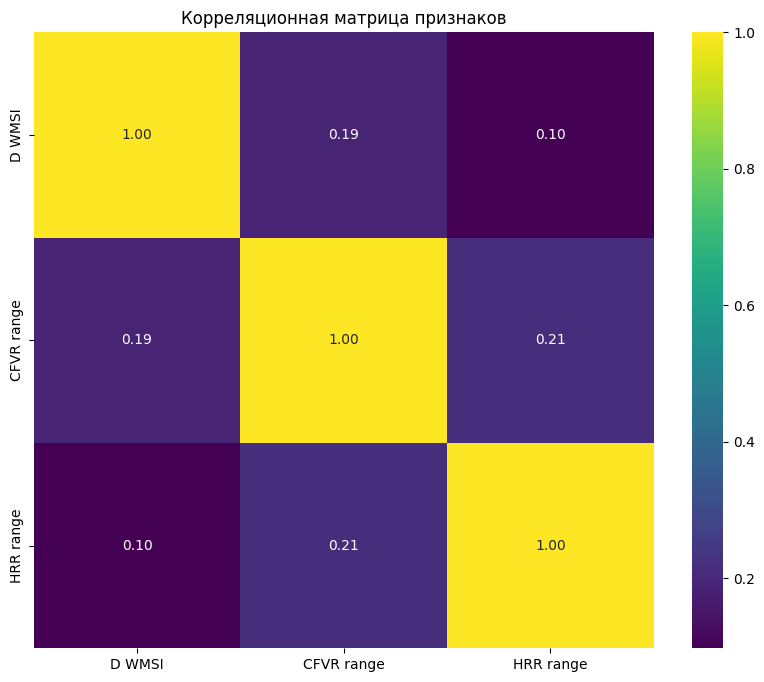

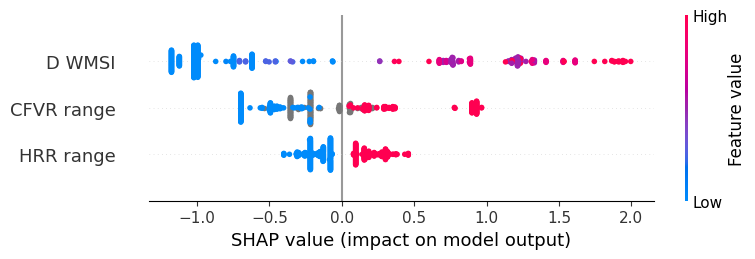

In [ ]:
  # @title Матрица корреляции для отобранных признаков; SHAP
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)
X_corr = X_boost.copy()
X_corr[cat_features] = encoder.fit_transform(X_corr[cat_features])

corr_matrix = X_corr.corr(method='pearson')

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt=".2f")

plt.title('Корреляционная матрица признаков')
plt.show()

explainer = shap.TreeExplainer(cat_model)
shap_values = explainer.shap_values(X_boost)
shap.summary_plot(shap_values, X_boost)

In [ ]:
# @title PCA для отобранных признаков
fig, axes = plt.subplots(3, 1, figsize=(6, 13))

datasets = [
    ("df_KNN", df_final),
    ("df_MICE", df_MICE),
    ("df_MissForest", df_miss_forest)
]

for ax, (name, data) in zip(axes, datasets):
    data=data[optimal_cols]
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    ax.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
    ax.axhline(0.8, color='r', linestyle='--', label='80%')
    ax.axhline(0.95, color='g', linestyle='--', label='95%')
    ax.set_xlabel('Кол-во компонент')
    ax.set_ylabel('Накопленная дисперсия')
    ax.set_title(f'PCA для {name}')
    ax.legend()
    ax.grid()

    n_components = len(list(filter(lambda x: x <= 0.95, explained_variance)))
    print(f"{name}: Компоненты, объясняющие 95% дисперсии = {n_components}")

plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))

for name, data in datasets:
    data=data[optimal_cols]
    X_numeric = data.select_dtypes(include=[np.number])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_numeric)
    pca = PCA()
    X_pca = pca.fit_transform(X_scaled)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)

    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o', label=name)

plt.axhline(0.8, color='r', linestyle='--', label='80%')
plt.axhline(0.95, color='g', linestyle='--', label='95%')
plt.xlabel('Кол-во компонент')
plt.ylabel('Накопленная дисперсия')
plt.title('PCA сравнение')
plt.legend()
plt.grid()
plt.show()


In [ ]:
# @title Веса главных компонент по всем признакам
data=df_MICE[optimal_cols]
X_numeric = data.select_dtypes(include=[np.number])
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_numeric)
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

loadings_df = pd.DataFrame(
    data=pca.components_,
    columns=X_numeric.columns,
    index=[f'PC{i+1}' for i in range(pca.n_components_)]
)
def get_most_important_features(component, loadings_df, n_features=1):
    pc_loadings = loadings_df.loc[component]
    most_important = pc_loadings.abs().sort_values(ascending=False).head(n_features)
    return loadings_df.loc[component, most_important.index]
    # return loadings_df.loc[component]

for i in range(1, len(X_boost.columns)):
  print(get_most_important_features(f'PC{i}', loadings_df, n_features=1))

# print(new_X)
plt.figure(figsize=(15, 8))
sns.heatmap(loadings_df.head(10), cmap='vlag', annot=False)
plt.title('Тепловая карта нагрузок PCA (первые  компонент)')
plt.show()

In [ ]:
# @title Optuna для XGBoostClassifier
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.05, 0.4, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 50, 300),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 20),
        'gamma': trial.suggest_float('gamma', 0.1, 5.0, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True), # Усилили L1
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True), # Усилили L2

        # 2. Позволяем Optuna найти лучший баланс
        # Соотношение 62/29 ≈ 2.14. Ищем вокруг этого значения.
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.5, 3.0),

        # Стандартные параметры
        'use_label_encoder': False,
        'eval_metric': 'logloss' # logloss лучше подходит для оптимизации вероятностей
    }

    model = XGBClassifier(**params, random_state=42)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_boost, y, scoring='roc_auc', cv=cv, n_jobs=-1)

    return np.mean(scores)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=1000)


print("Best trial:")
print("AUC:", study.best_value)
print("Params:", study.best_params)


best_params = study.best_params
best_params['eval_metric'] = 'auc' #не влияет на обучение
model = XGBClassifier(**best_params, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)[:, 1]
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))
y_train_pred_proba = model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))

y_pred_proba = model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(model, X_test, y_test)
plt.show()

In [ ]:
# @title Optuna для CatBoostClassifier
def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 80, 300),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "depth": trial.suggest_int("depth", 3, 8),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("border_count", 32, 200),
        "scale_pos_weight": scale_pos_weight,
        "verbose": False,
        "loss_function": "Logloss",
        "eval_metric": "AUC",
        "random_seed": 42,
        "early_stopping_rounds": 50
    }

    model = CatBoostClassifier(**params)
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    auc_scores = cross_val_score(model, X_boost, y, cv=cv, scoring="recall")
    return np.mean(auc_scores)

# Запуск Optuna
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=1000, show_progress_bar=True)

print("Лучшие параметры:\n", study.best_params)

# Финальная модель с лучшими параметрами
best_params = study.best_params
best_params.update({
    "loss_function": "Logloss",
    "eval_metric": "Recall",
    "random_seed": 42,
    "early_stopping_rounds": 50,
    "verbose": 100
})

best_model = CatBoostClassifier(**best_params)
best_model.fit(X_train, y_train)

# Оценка
y_pred = best_model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("\nClassification report:\n", classification_report(y_test, y_pred))
print("\nConfusion matrix:\n", confusion_matrix(y_test, y_pred))

# AUC
y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]
print("ROC AUC (Train):", roc_auc_score(y_train, y_train_pred_proba))
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
print("ROC AUC:", roc_auc_score(y_test, y_pred_proba))

RocCurveDisplay.from_estimator(best_model, X_test, y_test)
plt.show()